In [1]:
import pytorch_lightning as pl
import glob
import os
import numpy as np

import torch
from torchvision import transforms
import torchvision.models as models

import matplotlib.pyplot as plt

In [2]:
seed=42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

pl.utilities.seed.seed_everything(seed)

Global seed set to 42


42

In [3]:
SiZE = 28

In [4]:
class CustomImageDataset(torch.utils.data.Dataset):
    def find_classes(self, img_dir):
        self.classes = [s[len(img_dir) + 1:-4] for s in glob.glob(f"{img_dir}/*.jpg")]
        return self.classes
    
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.classes = self.find_classes(img_dir)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.classes)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.classes[idx] + ".jpg")
        image = plt.imread(img_path)
        label = idx
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [5]:
transform = transforms.Compose(
[
    transforms.ToTensor(),
    transforms.RandomPerspective(distortion_scale=0.3, p=1.0, fill=1),
    transforms.ColorJitter(brightness=(0.5, 1), contrast=(0.5, 1), saturation=(0.1, 1)),
    transforms.Resize((35, 35)),
    transforms.RandomCrop(28),
    # transforms.Normalize((0.1307,), (0.3081,))
])

In [6]:
train_dataset = CustomImageDataset("./signs", transform=transform)

test_dataset = CustomImageDataset("./signs", transform=transform)


C:\Users\prokofyev\anaconda3\envs\signs\lib\site-packages\torchvision\transforms\functional.py:150: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_numpy.cpp:178.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


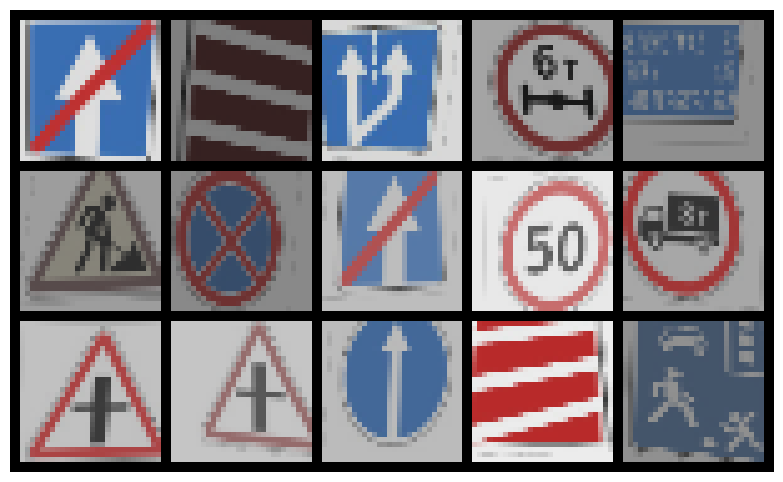

In [7]:
from torchvision.utils import make_grid

plt.figure(figsize=(10, 6))
plt.axis('off')
plt.imshow(make_grid([train_dataset[i][0] for i in 
                      np.random.randint(len(train_dataset), size=15)], nrow=5).permute(1, 2, 0));

In [8]:
BATCH_SIZE = 4

In [9]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=0, drop_last=True)
test_loader =  torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=0)

In [10]:
loss = torch.nn.CrossEntropyLoss()

In [11]:
import torchmetrics

class Accuracy(torchmetrics.Metric):
    def __init__(self):

        super().__init__()

        self.add_state("correct", default=torch.tensor(0.0), dist_reduce_fx="sum")
        self.add_state("total", default=torch.tensor(0.0), dist_reduce_fx="sum")

    def update(self, preds, target):

        self.correct += torch.sum(preds.argmax(dim=1) == target).item()
        self.total += target.numel()

    def compute(self):
        return  self.correct/self.total

acc = Accuracy()

C:\Users\prokofyev\anaconda3\envs\signs\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (Accuracy). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


In [12]:
class ImagenetTransferLearning(pl.LightningModule):
    def __init__(self):
        super().__init__()

        backbone = models.resnet50(pretrained=True)
        num_filters = backbone.fc.in_features
        layers = list(backbone.children())[:-1]
        self.feature_extractor = torch.nn.Sequential(*layers)

        num_target_classes = len(train_dataset)
        self.classifier = torch.nn.Linear(num_filters, num_target_classes)

        
    def forward(self, x):
        self.feature_extractor.eval()
        with torch.no_grad():
            representations = self.feature_extractor(x).flatten(1)
        x = self.classifier(representations)
        return x
    
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        pred = self.forward(x)
        loss_value = loss(pred, y)
        acc.update(pred, y)
        self.log('loss/train', loss_value, on_epoch=True)
        self.log('accuracy/train', acc.compute(), on_epoch=True)
        return loss_value

    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        pred = self.forward(x)
        loss_value = loss(pred, y)
        acc.update(pred, y)
        self.log('loss/valid', loss_value, on_epoch=True)
        self.log('accuracy/valid', acc.compute(), on_epoch=True)
        return loss_value
      

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1.0e-3)
        lr_scheduler = {
            "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.3, verbose=True),
            "interval": "epoch",
            "frequency": 1,
            "monitor": "accuracy/valid",
            "strict": True,
            "name": None,
        }
        return {'optimizer': optimizer, 'lr_scheduler': lr_scheduler}

In [13]:
# model = ImagenetTransferLearning()
model = ImagenetTransferLearning.load_from_checkpoint(r".\model_55_classes.ckpt")


C:\Users\prokofyev\anaconda3\envs\signs\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\prokofyev\anaconda3\envs\signs\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
logger = pl.loggers.TensorBoardLogger(
    'lightning_logs', 
    name='tune_imagenet'                   
)

In [15]:
train_dataset.classes

['1.10',
 '1.16',
 '1.17',
 '1.2',
 '1.20.1',
 '1.20.2',
 '1.22',
 '1.25',
 '1.34.3',
 '2.1',
 '2.3.1',
 '2.4',
 '3.1',
 '3.11',
 '3.12',
 '3.13',
 '3.2',
 '3.20',
 '3.24',
 '3.25',
 '3.27',
 '3.28',
 '3.4',
 '4.1.1',
 '4.1.4',
 '4.2.1',
 '4.2.3',
 '5.15.1',
 '5.15.3',
 '5.15.5',
 '5.15.6',
 '5.16',
 '5.18',
 '5.19.1',
 '5.19.2',
 '5.21',
 '5.23.1',
 '5.5',
 '5.6',
 '5.9',
 '6.10.1',
 '6.11',
 '6.12',
 '6.13',
 '6.16',
 '7.12',
 '7.3',
 '8.2.1',
 '8.2.2',
 '8.2.3',
 '8.2.4',
 '8.22.1',
 '8.22.2',
 '8.22.3',
 '8.23']

In [16]:
trainer = pl.Trainer(
    gpus=0,
    logger=logger,
    max_epochs = 10000)

C:\Users\prokofyev\anaconda3\envs\signs\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [17]:
trainer.fit(
    model, train_loader,
    val_dataloaders=test_loader)

Missing logger folder: lightning_logs\tune_imagenet

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 23.5 M
1 | classifier        | Linear     | 112 K 
-------------------------------------------------
23.6 M    Trainable params
0         Non-trainable params
23.6 M    Total params
94.483    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\prokofyev\anaconda3\envs\signs\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\prokofyev\anaconda3\envs\signs\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\prokofyev\anaconda3\envs\signs\lib\site-packages\pytorch_lightning\trainer\trainer.py:1892: PossibleUserWarning: The number of training batches (13) is smaller than the logging 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

C:\Users\prokofyev\anaconda3\envs\signs\lib\site-packages\pytorch_lightning\trainer\trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
